In [39]:
import os

import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option("display.max_rows", 4000)
pd.set_option("display.max_columns", 100)

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA = '../data'

DEALS = os.path.join(DATA, 'deals.csv')
TRANSACTIONS = os.path.join(DATA, 'trxn.csv')
CLIENTS = os.path.join(DATA, 'client.csv')
MCC_INFO = os.path.join(DATA, 'dict_mcc.csv')
AUM_INFO = os.path.join(DATA, 'aum.csv')
BALANCE_INFO = os.path.join(DATA, 'balance.csv')
CALL_INFO = os.path.join(DATA, 'appl.csv')
TARGET_INFO = os.path.join(DATA, 'funnel.csv')

In [3]:
target = pd.read_csv(TARGET_INFO, sep=',')

In [4]:
target.head()

,client_id,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,region_cd
0,7513301859607023584,0,NaN,1,7,13.0,571533.0,15717.0,0.0,0.0,0.0,571852.0,472605.0,10.4,12548.0,86.0
1,9157009756404187626,0,NaN,1,3,13.0,3642369.0,94787.0,0.0,0.0,84823.0,3642369.0,3314257.0,8.9,77210.0,2.0
2,-1893104556496814867,0,NaN,1,5,16.0,352826.0,5500.0,0.0,6822.0,0.0,265893.0,204534.0,8.9,5508.0,52.0
3,6886062013213911831,0,NaN,1,4,3.0,6070615.0,40580.0,0.0,30401.0,0.0,2005731.0,1825051.0,7.9,40583.0,86.0
4,-8156468515495593794,1,138018.05,1,7,14.0,3642369.0,97156.0,81488.0,0.0,160308.0,3642369.0,3314257.0,10.4,78108.0,27.0


## Features

In [5]:
target['feature_5_0'] = target.feature_5 < 1e-10
target['feature_5_1'] = target.feature_5 > 1e-10

In [6]:
target['feature_4_0'] = target.feature_4 < 1e-10
target['feature_4_1'] = target.feature_4 > 1e-10

In [7]:
for col in ['feature_7', 'feature_8', 'feature_9', 'feature_10']:
    target[col] = target[col].fillna(target[col].mode()[0])

In [8]:
client = pd.read_csv(CLIENTS, sep=',')

client.loc[client.education.isna(), 'education'] = 'MISSING'
client.loc[(client.city > 1000) | (client.city == -1), 'city'] = 1001
client.loc[(client.region > 60) | (client.region == -1), 'region'] = 61
client['gender'] = client['gender'].fillna(value='F')
client['age'] = client['age'].fillna(client['age'].mode()[0])

client.head()

,client_id,gender,age,region,city,citizenship,education,job_type
0,7513301859607023584,F,33.0,0,115,RUSSIA,MISSING,NaN
1,9157009756404187626,F,59.0,17,668,RUSSIA,MISSING,NaN
2,-1893104556496814867,M,51.0,28,65,RUSSIA,MISSING,NaN
3,6886062013213911831,F,56.0,0,40,RUSSIA,MISSING,NaN
4,-8156468515495593794,F,34.0,61,1001,RUSSIA,HIGHER_PROFESSIONAL,NaN


In [9]:
client = pd.get_dummies(client, columns=['education', 'job_type', 'citizenship', 'region', 'city', 'gender'])

In [10]:
target = target.set_index('client_id').sort_index()
client = client.set_index('client_id').sort_index()

In [13]:
pd_train = target.join(client)
pd_train.shape

(21498, 844)

In [25]:
pd_train.head()

,sale_flg,sale_amount,contacts,feature_1,client_segment,feature_2,feature_3,feature_4,feature_5,feature_6,...,city_982,city_985,city_987,city_988,city_992,city_993,city_995,city_1001,gender_F,gender_M
client_id,,,,,,,,,,,,,,,,,,,,,
-9221941791080978530,0,NaN,1,9,13.0,1821184.0,79089.0,132280.0,0.0,166263.0,...,0,0,0,0,0,0,0,0,0,1
-9220369594510368140,0,NaN,1,1,13.0,3642369.0,11288.0,6556.0,0.0,12464.0,...,0,0,0,0,0,0,0,0,1,0
-9220236243053692422,1,32920.9,2,1,3.0,3642369.0,24469.0,23073.0,16764.0,49060.0,...,0,0,0,0,0,0,0,0,1,0
-9220233431709087652,0,NaN,1,6,1.0,1371274.0,77447.0,27857.0,61894.0,15563.0,...,0,0,0,0,0,0,0,0,1,0
-9219699286371310531,0,NaN,1,7,3.0,352826.0,5500.0,0.0,4244.0,0.0,...,0,0,0,0,0,0,0,1,0,1


## Train

In [29]:
class KFoldGenerator:
    def __init__(self, path, df):
        locs = {v: k for k, v in enumerate(pd_train.index)}
        
        folds = []
        
        for i in range(5):
            with open(os.path.join(path, f'fold_{i}_train.txt'), mode='r') as inp:
                tr = np.array([*map(int, inp)])
            with open(os.path.join(path, f'fold_{i}_test.txt'), mode='r') as inp:
                te = np.array([*map(int, inp)])
            folds.append((tr, te))

        folds = [
            ([locs[e] for e in fold_train],
             [locs[e] for e in fold_valid], )
            for fold_train, fold_valid in folds
        ]
        
        self.folds = folds
        
    def __iter__(self):
        yield from self.folds
        


kfold = KFoldGenerator(path='../folds/', df=pd_train)

In [ ]:
# I'd better use :)

# from sklearn.model_selection import StratifiedKFold

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=72)

In [24]:
import lightgbm as lgb

In [31]:
X_train = lgb.Dataset(
    data=pd_train.drop(['sale_flg', 'sale_amount', 'contacts', 'region_cd'], axis=1),
    label=pd_train['sale_flg'].to_numpy(),
)

In [32]:
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    accuracy_score,
)


params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'subsample': 0.7,
    'class_weight': 'balanced',
    'colsample_bytree': 0.7,
    'max_depth': 5,
    'num_leaves': 256,
}


def update_learning_rate(num_rounds):
    if num_rounds <= 550:
        return 0.05
    return 0.03

In [34]:
%%time

trees = 1000
cv = lgb.cv(params, X_train, show_stdv=False, verbose_eval=True,
            num_boost_round=trees, early_stopping_rounds=50,
            return_cvbooster=True, folds=kfold)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 2873, number of negative: 14325
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the train set: 17198, number of used features: 251
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 2819, number of negative: 14379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2625
[LightGBM] [Info] Number of data points in the tra

In [35]:
cvbooster = cv.pop('cvbooster', None)

In [36]:
cv = pd.DataFrame(cv)

auc-mean    0.971243
auc-stdv    0.001609
Name: 999, dtype: float64


999

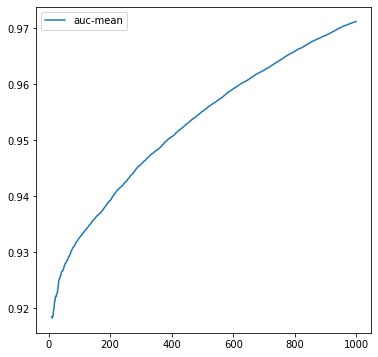

In [37]:
cv[10:].plot(figsize=(6, 6), y=['auc-mean'])
print(cv.loc[cv['auc-mean'].values.argmax()])
trees = cv['auc-mean'].values.argmax()
trees

In [40]:
feature_importance = []

for booster in cvbooster.boosters:
    feature_importance_ = pd.Series(
        data=booster.feature_importance('split'),
        index=booster.feature_name(),
    )
    feature_importance.append(feature_importance_)
    
feature_importance = pd.concat(feature_importance, axis=1)

feature_importance_mean = feature_importance.median(axis=1).astype(int).rename('mean')
feature_importance_std = feature_importance.std(axis=1).rename('std')

indices = feature_importance_mean.argsort()
feature_importance = feature_importance.iloc[indices]
feature_importance_mean = feature_importance_mean[indices]
feature_importance_std = feature_importance_std[indices]

feature_importance_mean[::-1]

feature_4                                1361
feature_6                                1224
age                                      1042
feature_8                                 888
feature_5                                 880
feature_3                                 853
feature_2                                 752
client_segment                            749
feature_9                                 706
feature_7                                 683
feature_10                                641
feature_1                                 632
education_MIDDLE_PROFESSIONAL             177
education_HIGHER_PROFESSIONAL             154
education_MISSING                         147
region_34                                 118
gender_F                                  116
city_1001                                 113
city_668                                  101
city_104                                   96
city_123                                   94
education_PRIMARY_PROFESSIONAL    

In [41]:
feature_importance = []

for booster in cvbooster.boosters:
    feature_importance_ = pd.Series(
        data=booster.feature_importance('gain'),
        index=booster.feature_name(),
    )
    feature_importance.append(feature_importance_)
    
feature_importance = pd.concat(feature_importance, axis=1)

feature_importance_mean = feature_importance.mean(axis=1).rename('mean')
feature_importance_std = feature_importance.std(axis=1).rename('std')

indices = feature_importance_mean.argsort()
feature_importance = feature_importance.iloc[indices]
feature_importance_mean = feature_importance_mean[indices]
feature_importance_std = feature_importance_std[indices]

feature_importance_mean[::-1]

education_MISSING                        40569.745038
client_segment                            7571.571747
feature_4                                 5839.995825
education_HIGHER_PROFESSIONAL             5153.393455
education_MIDDLE_PROFESSIONAL             4355.245375
feature_6                                 4099.022962
feature_5                                 3737.411330
feature_9                                 3681.597804
feature_2                                 3096.559854
age                                       2837.752773
feature_3                                 2420.657391
feature_8                                 2202.541311
feature_1                                 2139.511478
education_FULL_GENERAL                    2122.457249
feature_7                                 1934.310113
feature_10                                1641.562100
education_PRIMARY_PROFESSIONAL             802.248430
education_HIGHER_PROFESSIONAL_PARTIAL      795.313371
education_TWO_AND_MORE_HIGHE

<AxesSubplot:>

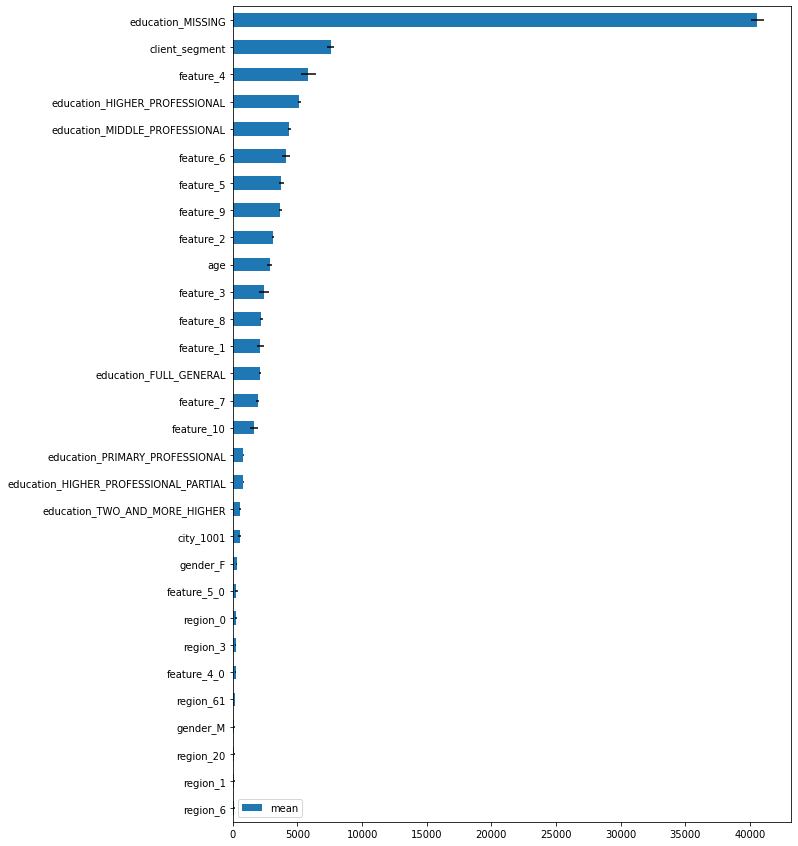

In [43]:
pd.concat([
    feature_importance_mean,
    feature_importance_std,
], axis=1).iloc[-30:].plot.barh(y='mean', figsize=(10, 15), xerr='std')

<AxesSubplot:>

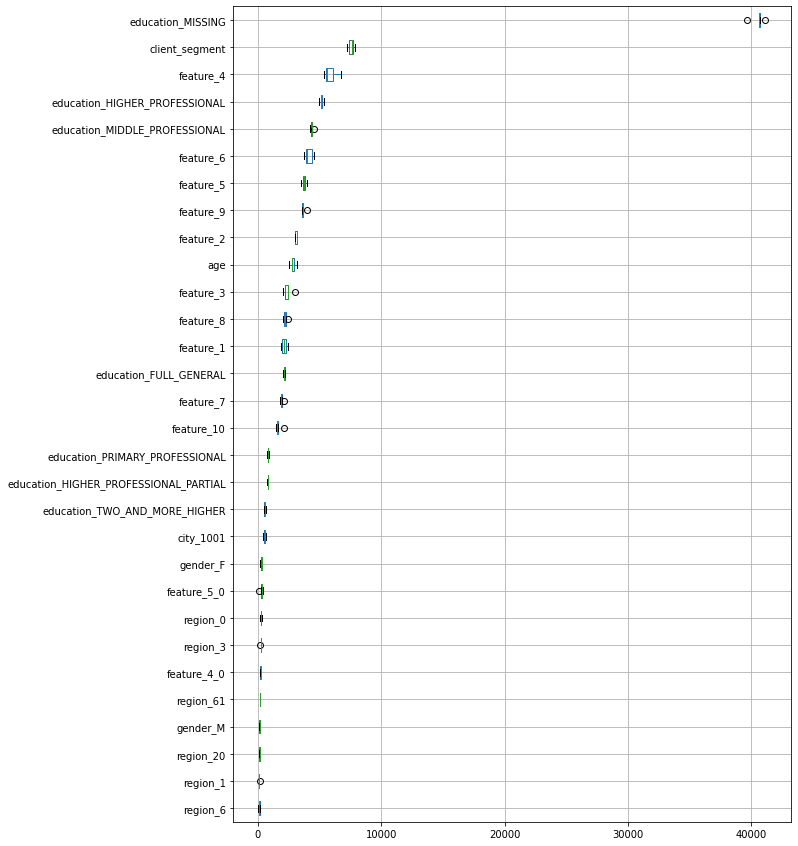

In [44]:
feature_importance.iloc[-30:].T.boxplot(figsize=(10, 15), vert=False)

In [82]:
def eval_metrics(y_true, y_score, earnings, contacts_cnt, thrsh=0.5):
    auc = roc_auc_score(y_true, y_score)
    
    y_pred = y_score > thrsh
    
    acc = accuracy_score(y_true, y_pred)
    pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    anic = (y_pred * (earnings - 4000 * contacts_cnt)).mean()
    
    return auc, acc, pre, rec, f1, anic

In [69]:
submission_pull = []

for (_, valid_idx), booster in zip(kfold, tqdm(cvbooster.boosters)):
    clients_valid, X_valid, y_valid = (
        pd_train.iloc[valid_idx].index,
        pd_train.loc[:, X_train.get_feature_name()].iloc[valid_idx],
        pd_train.loc[:, 'sale_flg'].iloc[valid_idx],
    )
    
    submission = pd.DataFrame(index=clients_valid)
    submission.index = submission.index.rename('client_id')
    submission['scores'] = booster.predict(X_valid)
    
    submission_pull.append(submission)
    
submission = pd.concat(submission_pull, axis=0)
submission.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,scores
client_id,
-2918739578801888500,0.878588
-4569470415387261653,0.581767
-330127410754871235,0.607495
-8339249258774556753,0.175772
-308621990635499048,0.000058


In [70]:
submission = submission.join(pd_train[['sale_flg', 'sale_amount', 'contacts']])
submission['sale_amount'] = submission['sale_amount'].fillna(0)
submission.head()

,scores,sale_flg,sale_amount,contacts
client_id,,,,
-9217522148893126271,0.560946,1,8278.15,2
-9217522148893126271,0.522717,1,8278.15,2
-9217522148893126271,0.540371,1,8278.15,2
-9217522148893126271,0.594746,1,8278.15,2
-9217522148893126271,0.567871,1,8278.15,2


In [71]:
submission.shape, pd_train.shape

((21495, 4), (21498, 844))

In [73]:
thresholds = np.linspace(0, 1, 1000)

scores = [
    eval_metrics(submission['sale_flg'], submission['scores'],
                 submission['sale_amount'], submission['contacts'], thrsh)
    for thrsh in tqdm(thresholds, position=0)
]

scores = np.asarray(scores)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/v.bugaevskii/.conda/envs/idao2021/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

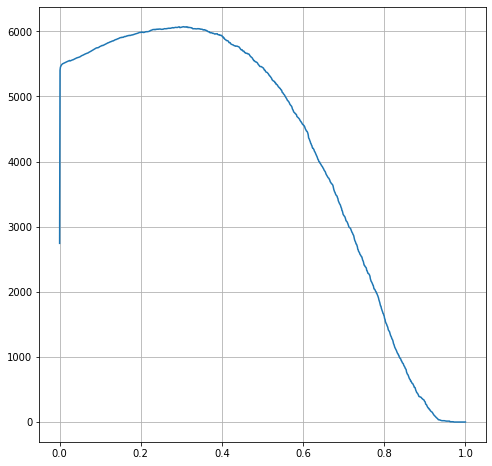

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))

_ = ax.plot(thresholds, scores[:, -1])
_ = ax.grid()

In [85]:
thrsh_best = thresholds[np.argmax(scores[:, -1])]
metrics_best = eval_metrics(
    submission['sale_flg'], submission['scores'],
    submission['sale_amount'], submission['contacts'],
    thrsh_best,
)

print("ROC AUC:   {:.6f}\n"
      "Accuarcy:  {:.6f}\n"
      "Precision: {:.6f}\n"
      "Recall:    {:.6f}\n"
      "F1-score:  {:.6f}\n"
      "ANIC:      {:.6f}\n".format(*metrics_best))

ROC AUC:   0.971234
Accuarcy:  0.902629
Precision: 0.638344
Recall:    0.923496
F1-score:  0.754889
ANIC:      6071.464468

